In [1]:
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import math

pd.options.display.max_columns = 200

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

# Convert geojson into parquet

In [3]:
def build_polygon_features(df):
    polygon = df["geometry"]
    df["area"] = polygon.area
    df["perimeter"] = polygon.perimeter

    df["aspect_ratio"] = polygon.apply(lambda x: x.minimum_rotated_rectangle.exterior.xy[0][0] / x.minimum_rotated_rectangle.exterior.xy[1][0]) 

    df["compactness"] = 4 * math.pi * df["area"] / (df["perimeter"] ** 2)
    df["elongation"] = (4 * 3.141592653589793 * df["area"]) / (df["perimeter"] ** 2)

    df["convexity"] = df["area"] / polygon.convex_hull.area

    df["num_vertices"] = polygon.apply(lambda x: len(x.exterior.coords)) 
    
    tot_angles = []
    for pol in polygon:
        coords = list(pol.exterior.coords)

        angles = ";"
        for i in range(len(coords) - 1):
            x1, y1 = coords[i]
            x2, y2 = coords[i + 1]
            if i + 2 < len(coords):
                x3, y3 = coords[i + 2]
            else:
                x3, y3 = coords[1]

            angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
            angle = (angle + 540) % 360  # Convert negative angles to positive
            angles += str(angle) + ";"
        tot_angles.append(angles)
    df["angles"] = tot_angles

    reference_point = Point(0, 0)  # Replace with your reference point
    df["distance_to_reference"] = polygon.centroid.apply(lambda x: x.distance(reference_point))

    return df

In [4]:
# train_df = gpd.read_file('train.geojson', index_col=0)
# test_df = gpd.read_file('test.geojson', index_col=0)

# train_df = build_polygon_features(train_df)
# test_df = build_polygon_features(test_df)

# train_df["wkt_polygon"] = train_df['geometry'].apply(lambda x: x.wkt)
# test_df["wkt_polygon"] = test_df['geometry'].apply(lambda x: x.wkt)

# train_df.drop(columns=["geometry"]).to_parquet("train.parquet", engine="pyarrow")
# test_df.drop(columns=["geometry"]).to_parquet("test.parquet", engine="pyarrow")

# Load the data

In [108]:
## Read csvs
from shapely import wkt

train_df = pd.read_parquet('train.parquet', engine="pyarrow")
test_df = pd.read_parquet('test.parquet', engine="pyarrow")

train_df["geometry"] = train_df['wkt_polygon'].apply(lambda x: wkt.loads(x))
train_df = gpd.GeoDataFrame(train_df.drop(columns=["wkt_polygon"]))
test_df["geometry"] = test_df['wkt_polygon'].apply(lambda x: wkt.loads(x))
test_df = gpd.GeoDataFrame(test_df.drop(columns=["wkt_polygon"]))

In [109]:
from matplotlib import pyplot as plt
plt.hist(train_df['change_type'])
plt.show()

C:\Users\bouet\AppData\Local\Temp\ipykernel_2040\2087683645.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


### Analyse polygones

In [110]:
n = 0

Area: 3.36e-08
Perimeter: 0.00074
Aspect Ratio: 0.082
Compactness: 0.78
Elongation: 0.78
Convexity: 1.0
Number of Vertices: 5
Angles: [88.16, 93.85, 84.74, 93.25]
Centroid: POINT (2.9 35.42)
Distance to Reference Point: 35.54


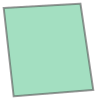

In [111]:
n += 1
polygon = test_df["geometry"][n]

area = polygon.area
perimeter = polygon.length

bounding_box = polygon.minimum_rotated_rectangle
box_width, box_height = bounding_box.exterior.xy
aspect_ratio = box_width[0] / box_height[0]

compactness = 4 * math.pi * area / (perimeter ** 2)
elongation = (4 * math.pi * area) / (perimeter ** 2)

convex_hull = polygon.convex_hull
convexity = area / convex_hull.area

num_vertices = len(polygon.exterior.coords)

coords = list(polygon.exterior.coords)

angles = []
for i in range(len(coords) - 1):
    x1, y1 = coords[i]
    x2, y2 = coords[i + 1]
    if i + 2 < len(coords):
        x3, y3 = coords[i + 2]
    else:
        x3, y3 = coords[1]

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    angle = (angle + 540) % 360  # Convert negative angles to positive
    angles.append(angle)

centroid = polygon.centroid

reference_point = Point(0, 0)  # Replace with your reference point
distance_to_reference = centroid.distance(reference_point)


print(f"Area: {area:.2e}")
print(f"Perimeter: {perimeter:.5f}")
print(f"Aspect Ratio: {aspect_ratio:.3f}")
print(f"Compactness: {compactness:.2f}")
print(f"Elongation: {elongation:.2f}")
print(f"Convexity: {convexity:.1f}")
print(f"Number of Vertices: {num_vertices}")
print(f"Angles: {[round(angle, 2) for angle in angles]}")
print(f"Centroid: POINT ({round(centroid.x, 2)} {round(centroid.y, 2)})")
print(f"Distance to Reference Point: {round(distance_to_reference, 2)}")
polygon

In [112]:
def Convert_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        return datetime.strptime(str(x), '%d-%m-%Y').date()
    except (ValueError, TypeError):
        return pd.NaT

In [113]:
def Format_data(df : gpd.GeoDataFrame) -> pd.DataFrame :
    """fomrmat the geopandas dataframe to a correct dataframe with one hoit encoded columns and normalized values

    Args:
        df (gpd.GeoDataFrame): The geopandas dataframe to format

    Returns:
        pd.DataFrame: The correct formated dataframe
    """
    #Convert urban types and geography types to one hot by hand, because mixed values are possible
    urban_types = df['urban_type'].str.split(',', expand = True)
    geography_types = df['geography_type'].str.split(',', expand = True)

    unique_urban_types = set(urban_types.values.flatten()) - {None}
    unique_geography_types = set(geography_types.values.flatten()) - {None}
    one_hot_encoded = pd.DataFrame(index=df.index)

    for urban_type in unique_urban_types:
        one_hot_encoded[urban_type] = urban_types.apply(lambda row: 1 if urban_type in row.values else 0, axis=1)

    for geography_type in unique_geography_types:
        one_hot_encoded[geography_type] = geography_types.apply(lambda row: 1 if geography_type in row.values else 0, axis=1)
    
    df_oh = pd.concat([df, one_hot_encoded], axis=1)
    df_oh = df_oh.drop(['urban_type', 'geography_type'], axis = 1)

    df_oh = df_oh.drop(['N', 'A', 'index'], axis = 1)

    bool_cols = [c for c in df_oh if df_oh.dtypes[c] == "bool"]
    df_oh[bool_cols] = df_oh[bool_cols].astype(int)

    df_oh.loc[:,'date0'] = pd.to_datetime(df_oh['date0'].apply(Convert_date), format='%Y-%m-%d')
    df_oh.loc[:,'date1'] = pd.to_datetime(df_oh['date1'].apply(Convert_date), format='%Y-%m-%d')
    df_oh.loc[:,'date2'] = pd.to_datetime(df_oh['date2'].apply(Convert_date), format='%Y-%m-%d')
    df_oh.loc[:,'date3'] = pd.to_datetime(df_oh['date3'].apply(Convert_date), format='%Y-%m-%d')
    df_oh.loc[:,'date4'] = pd.to_datetime(df_oh['date4'].apply(Convert_date), format='%Y-%m-%d')


    def order_dates(row):
        res = [None]*5*8
        chronological_order = sorted(enumerate(row.loc[["date0", "date1", "date2", "date3", "date4"]]), key=lambda x: x[1])
        for i, (date_i, _) in enumerate(chronological_order):
            res[i] = row[f"date{date_i}"]
            res[5 + i] = row[f"change_status_date{date_i}"]
            res[10 + i*6: 10 + (i+1)*6] = row[[
                f"img_red_mean_date{date_i+1}",
                f"img_green_mean_date{date_i+1}",
                f"img_blue_mean_date{date_i+1}",
                f"img_red_std_date{date_i+1}",
                f"img_green_std_date{date_i+1}",
                f"img_blue_std_date{date_i+1}",
            ]]
        return res

    df_oh[
        [f"date{i}" for i in range(5)] + [
            f"change_status_date{i}" for i in range(5)
        ]+ [item for sublist in [
                [f"img_red_mean_date{i+1}",
                f"img_green_mean_date{i+1}",
                f"img_blue_mean_date{i+1}",
                f"img_red_std_date{i+1}",
                f"img_green_std_date{i+1}",
                f"img_blue_std_date{i+1}"]
                for i in range(5)
            ]
            for item in sublist
        ]
    ] = df_oh[
        [f"date{i}" for i in range(5)] + [
            f"change_status_date{i}" for i in range(5)
        ]+ [item for sublist in [
                [f"img_red_mean_date{i+1}",
                f"img_green_mean_date{i+1}",
                f"img_blue_mean_date{i+1}",
                f"img_red_std_date{i+1}",
                f"img_green_std_date{i+1}",
                f"img_blue_std_date{i+1}"]
                for i in range(5)
            ]
            for item in sublist
        ]
    ].apply(
        order_dates, axis=1, result_type='expand'
    ).values

    df_oh = pd.get_dummies(df_oh,columns=['change_status_date0',
    'change_status_date1', 'change_status_date2', 'change_status_date3',
    'change_status_date4'])

    def merge_angles_to_features(numbers):
        if len(numbers) <= 4:
            return [4] + [sorted(numbers)[i] if i < len(numbers) else 0 for i in range(4)]
        
        # Distribute values equally between the min and max
        min_val = min(numbers)
        max_val = max(numbers)
        step = (max_val - min_val) / 3
        
        merged_list = [min_val + i * step for i in range(4)]
        return [len(numbers)] + merged_list

    df_oh[["num_angles", 'mean_angle_1', 'mean_angle_2', 'mean_angle_3', 'mean_angle_4']] =  np.array(df_oh['angles'].apply(
        lambda x: merge_angles_to_features([float(val) for val in x.split(';') if val])
    ).values.tolist())
    df_oh = df_oh.drop(columns=["angles"])

    return df_oh

In [114]:
train_df_oh, test_df_oh = Format_data(train_df.copy()), Format_data(test_df.copy())

In [115]:
train_df_oh

,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,img_green_mean_date2,img_blue_mean_date2,img_red_std_date2,img_green_std_date2,img_blue_std_date2,img_red_mean_date3,img_green_mean_date3,img_blue_mean_date3,img_red_std_date3,img_green_std_date3,img_blue_std_date3,img_red_mean_date4,img_green_mean_date4,img_blue_mean_date4,img_red_std_date4,img_green_std_date4,img_blue_std_date4,img_red_mean_date5,img_green_mean_date5,img_blue_mean_date5,img_red_std_date5,img_green_std_date5,img_blue_std_date5,date0,date1,date2,date3,date4,area,perimeter,aspect_ratio,compactness,elongation,convexity,num_vertices,distance_to_reference,geometry,Sparse Urban,Urban Slum,Industrial,Rural,Dense Urban,Sparse Forest,Desert,River,Snow,Hills,Barren Land,Grass Land,Lakes,Farms,Dense Forest,Coastal,change_status_date0_Construction Done,change_status_date0_Construction Midway,change_status_date0_Construction Started,change_status_date0_Excavation,change_status_date0_Greenland,change_status_date0_Land Cleared,change_status_date0_Materials Dumped,change_status_date0_Materials Introduced,change_status_date0_Operational,change_status_date0_Prior Construction,change_status_date1_Construction Done,change_status_date1_Construction Midway,change_status_date1_Construction Started,change_status_date1_Excavation,change_status_date1_Greenland,change_status_date1_Land Cleared,change_status_date1_Materials Dumped,change_status_date1_Materials Introduced,change_status_date1_Operational,change_status_date1_Prior Construction,change_status_date2_Construction Done,change_status_date2_Construction Midway,change_status_date2_Construction Started,change_status_date2_Excavation,change_status_date2_Greenland,change_status_date2_Land Cleared,change_status_date2_Materials Dumped,change_status_date2_Materials Introduced,change_status_date2_Operational,change_status_date2_Prior Construction,change_status_date3_Construction Done,change_status_date3_Construction Midway,change_status_date3_Construction Started,change_status_date3_Excavation,change_status_date3_Greenland,change_status_date3_Land Cleared,change_status_date3_Materials Dumped,change_status_date3_Materials Introduced,change_status_date3_Operational,change_status_date3_Prior Construction,change_status_date4_Construction Done,change_status_date4_Construction Midway,change_status_date4_Construction Started,change_status_date4_Excavation,change_status_date4_Greenland,change_status_date4_Land Cleared,change_status_date4_Materials Dumped,change_status_date4_Materials Introduced,change_status_date4_Operational,change_status_date4_Prior Construction,num_angles,mean_angle_1,mean_angle_2,mean_angle_3,mean_angle_4
0,Road,125.773062,139.833243,134.900701,28.269984,28.264907,25.008032,150.766726,158.964529,149.356684,55.745311,47.576383,42.723218,104.614233,100.950353,102.844339,33.81316,33.064014,34.818012,93.371775,107.291113,89.827379,29.81204,28.328368,25.324294,92.291347,88.79425,79.570064,39.819949,30.86423,28.189604,2013-12-09,2016-09-10,2017-07-24,2018-08-01,2019-07-22,8.174601e-07,0.004137,3.503006,0.600210,0.600210,1.0,5,116.649502,"POLYGON ((112.16774 32.02198, 112.16845 32.020...",1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,4.0,68.643153,87.789826,93.114842,110.452179
1,Road,133.097679,145.38519,137.092518,23.683964,21.651242,20.271657,184.480155,186.896779,174.235331,42.130924,38.138137,35.142246,110.445556,103.413826,104.835541,30.670052,33.258905,36.139281,96.071674,107.061702,90.755556,24.89624,22.27518,22.080686,111.001421,102.096357,91.447834,37.129531,28.089549,25.901238,2013-12-09,2016-09-10,2017-07-24,2018-08-01,2019-07-22,4.394334e-07,0.002

In [116]:
# train_df_oh.drop(columns=["geometry"]).to_parquet("train_df_oh.parquet", engine="pyarrow")
# test_df_oh.drop(columns=["geometry"]).to_parquet("test_df_oh.parquet", engine="pyarrow")

In [15]:
stop run_all

SyntaxError: invalid syntax (613193831.py, line 1)

In [1]:
train_df_oh = pd.read_parquet("train_df_oh.parquet", engine="pyarrow")
test_df_oh = pd.read_parquet("test_df_oh.parquet", engine="pyarrow")

NameError: name 'pd' is not defined

In [142]:
train_df_oh.head(5)

,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,img_green_mean_date2,img_blue_mean_date2,img_red_std_date2,img_green_std_date2,img_blue_std_date2,img_red_mean_date3,img_green_mean_date3,img_blue_mean_date3,img_red_std_date3,img_green_std_date3,img_blue_std_date3,img_red_mean_date4,img_green_mean_date4,img_blue_mean_date4,img_red_std_date4,img_green_std_date4,img_blue_std_date4,img_red_mean_date5,img_green_mean_date5,img_blue_mean_date5,img_red_std_date5,img_green_std_date5,img_blue_std_date5,date0,date1,date2,date3,date4,area,perimeter,aspect_ratio,compactness,elongation,convexity,num_vertices,distance_to_reference,Sparse Urban,Urban Slum,Industrial,Rural,Dense Urban,Sparse Forest,Desert,River,Snow,Hills,Barren Land,Grass Land,Lakes,Farms,Dense Forest,Coastal,change_status_date0_Construction Done,change_status_date0_Construction Midway,change_status_date0_Construction Started,change_status_date0_Excavation,change_status_date0_Greenland,change_status_date0_Land Cleared,change_status_date0_Materials Dumped,change_status_date0_Materials Introduced,change_status_date0_Operational,change_status_date0_Prior Construction,change_status_date1_Construction Done,change_status_date1_Construction Midway,change_status_date1_Construction Started,change_status_date1_Excavation,change_status_date1_Greenland,change_status_date1_Land Cleared,change_status_date1_Materials Dumped,change_status_date1_Materials Introduced,change_status_date1_Operational,change_status_date1_Prior Construction,change_status_date2_Construction Done,change_status_date2_Construction Midway,change_status_date2_Construction Started,change_status_date2_Excavation,change_status_date2_Greenland,change_status_date2_Land Cleared,change_status_date2_Materials Dumped,change_status_date2_Materials Introduced,change_status_date2_Operational,change_status_date2_Prior Construction,change_status_date3_Construction Done,change_status_date3_Construction Midway,change_status_date3_Construction Started,change_status_date3_Excavation,change_status_date3_Greenland,change_status_date3_Land Cleared,change_status_date3_Materials Dumped,change_status_date3_Materials Introduced,change_status_date3_Operational,change_status_date3_Prior Construction,change_status_date4_Construction Done,change_status_date4_Construction Midway,change_status_date4_Construction Started,change_status_date4_Excavation,change_status_date4_Greenland,change_status_date4_Land Cleared,change_status_date4_Materials Dumped,change_status_date4_Materials Introduced,change_status_date4_Operational,change_status_date4_Prior Construction,num_angles,mean_angle_1,mean_angle_2,mean_angle_3,mean_angle_4
0,Road,125.773062,139.833243,134.900701,28.269984,28.264907,25.008032,150.766726,158.964529,149.356684,55.745311,47.576383,42.723218,104.614233,100.950353,102.844339,33.813160,33.064014,34.818012,93.371775,107.291113,89.827379,29.812040,28.328368,25.324294,92.291347,88.794250,79.570064,39.819949,30.864230,28.189604,2013-12-09,2016-09-10,2017-07-24,2018-08-01,2019-07-22,8.174601e-07,0.004137,3.503006,0.600210,0.600210,1.0,5,116.649502,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,4.0,68.643153,87.789826,93.114842,110.452179
1,Road,133.097679,145.385190,137.092518,23.683964,21.651242,20.271657,184.480155,186.896779,174.235331,42.130924,38.138137,35.142246,110.445556,103.413826,104.835541,30.670052,33.258905,36.139281,96.071674,107.061702,90.755556,24.896240,22.275180,22.080686,111.001421,102.096357,91.447834,37.129531,28.089549,25.901238,2013-12-09,2016-09-10,2017-07-24,2018-08-01,2019-07-22,4.394334e-07,0.002746,3.503024,0.732105,0.732105,1.0,5,116.649740,1,0,0,

In [143]:
def Set_dif_date_columns(df) :
    # df = df.fillna(0)

    dif1 = []
    dif2 = []
    dif3 = []
    dif4 = []

    for _,dates in df.loc[:,['date0', 'date1', 'date2', 'date3', 'date4']].iterrows():
        dif1.append((dates['date1'] - dates['date0']).days)
        dif2.append((dates['date2'] - dates['date1']).days)
        dif3.append((dates['date3'] - dates['date2']).days)
        dif4.append((dates['date4'] - dates['date3']).days)
    
    df.loc[:,'date_dif1'] = dif1
    df.loc[:,'date_dif2'] = dif2
    df.loc[:,'date_dif3'] = dif3   
    df.loc[:,'date_dif4'] = dif4  
    df = df.fillna(0)
    df = df.drop(['date0', 'date1', 'date2', 'date3','date4'], axis = 1)

    return df


In [144]:
train, test = Set_dif_date_columns(train_df_oh), Set_dif_date_columns(test_df_oh)

In [145]:
train.to_parquet("train_dataset.parquet", engine="pyarrow")
test.to_parquet("test_dataset.parquet", engine="pyarrow")

# Outlier study

In [2]:
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
import math

pd.options.display.max_columns = 200

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

In [3]:
train = pd.read_parquet("train_dataset.parquet", engine="pyarrow")
test = pd.read_parquet("test_dataset.parquet", engine="pyarrow")

In [4]:
from matplotlib import pyplot as plt

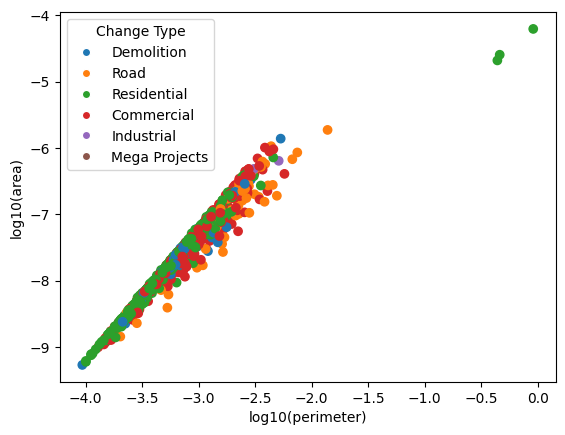

In [5]:
selection = np.random.choice(train.index, 1000)

scatter = plt.scatter(np.log10(train['perimeter'].loc[selection]),np.log10(train['area'].loc[selection]), c = train['change_type'].loc[selection].apply(lambda x: plt.cm.tab10(change_type_map[x])))
legend_entries = []
for change_type, color_code in change_type_map.items():
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', label=change_type, markerfacecolor=plt.cm.tab10(color_code)))

# Adding legends
plt.xlabel("log10(perimeter)")
plt.ylabel("log10(area)")
plt.legend(handles=legend_entries, title='Change Type')
plt.show()
plt.close()

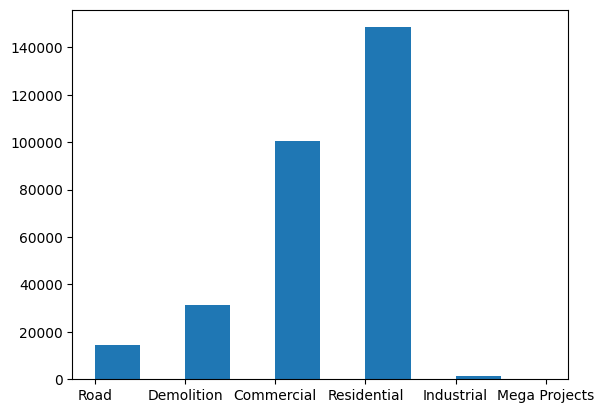

In [6]:
plt.hist(train['change_type'])
plt.show()
plt.close()

In [7]:
from supervised import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold

train.loc[:,'change_type'] = train['change_type'].apply(lambda x: change_type_map[x])

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns=["change_type"]), train["change_type"], test_size=0.25
)

n_splits = 5 

kf = KFold(n_splits=n_splits, shuffle=False)  # Set random_state for reproducibility

cv_splits = []
for train_index, val_index in kf.split(X_train):
    cv_splits.append([train_index, val_index])

for j in range(n_splits):
    plt.plot(cv_splits[j][0], np.random.rand(len(cv_splits[j][0]))*0.75+j, c="tab:blue")
    plt.plot(cv_splits[j][1], np.random.rand(len(cv_splits[j][1]))*0.75+j, c="tab:orange")
plt.savefig("split.png")
plt.close()

In [8]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [17]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Assuming X and y are your feature matrix and target labels
# Make sure y is a single column representing the class labels

# Check the class distribution before upsampling
print("Class distribution before downsampling and upsampling:", Counter(y_train))

# Downsampling classes with more than 50,000 samples
downsampler = RandomUnderSampler(sampling_strategy={"2": 50000, "3": 50000}, random_state=42)
X_train_downsampled, y_train_downsampled = downsampler.fit_resample(X_train, y_train.astype(str))

print("Class distribution after downsampling and before upsampling:", Counter(y_train_downsampled))

# Upsampling the remaining classes
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_downsampled, y_train_downsampled)

# Check the class distribution after upsampling
print("Class distribution after upsampling:", Counter(y_train_resampled))


Class distribution before downsampling and upsampling: Counter({2: 111387, 3: 75323, 0: 23610, 1: 10677, 4: 1001, 5: 111})
Class distribution after downsampling and before upsampling: Counter({'2': 50000, '3': 50000, '0': 23610, '1': 10677, '4': 1001, '5': 111})
Class distribution after upsampling: Counter({'0': 50000, '1': 50000, '2': 50000, '3': 50000, '4': 50000, '5': 50000})


In [18]:
for c in X_train_resampled:
    if X_train_resampled.dtypes[c] == "bool":
        X_train_resampled[c] = X_train_resampled[c].astype(int)
for c in X_train_downsampled:
    if X_train_downsampled.dtypes[c] == "bool":
        X_train_downsampled[c] = X_train_downsampled[c].astype(int)

In [19]:
model = AutoML(
    results_path="AutoMLResults_logloss_downsampled_50000_3600_lgbm",
    total_time_limit=3600,
    mode="Compete",
    ml_task="multiclass_classification",
    eval_metric="logloss", #"logloss", "f1", "accuracy"
    algorithms=["LightGBM"],
    # validation_strategy={"validation_type": "custom"},
    train_ensemble=False,
    stack_models=False,
    explain_level=0, #2 to have shap values, but take some time
    golden_features=False,
    features_selection=False,
    hill_climbing_steps=0,
)

model.fit(X_train_downsampled, y_train_downsampled.astype(int))

AutoML directory: AutoMLResults_logloss_downsampled_50000_3600_lgbm
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['LightGBM']
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'kmeans_features', 'boost_on_errors']
* Step adjust_validation will try to check up to 1 model


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


1_DecisionTree logloss 0.941554 trained in 7.23 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 5-fold CV Shuffle,Stratify
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

1_Default_LightGBM logloss 0.582406 trained in 296.15 seconds
* Step not_so_random will try to check up to 9 models


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

2_LightGBM logloss 0.583541 trained in 374.78 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

3_LightGBM logloss 0.734214 trained in 45.2 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

4_LightGBM logloss 0.579606 trained in 192.6 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

5_LightGBM logloss 0.581886 trained in 190.93 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

6_LightGBM logloss 0.655881 trained in 72.76 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

7_LightGBM logloss 0.57598 trained in 173.94 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

8_LightGBM logloss 0.578484 trained in 192.59 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

9_LightGBM logloss 0.690892 trained in 50.78 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

10_LightGBM logloss 0.583969 trained in 408.5 seconds
* Step kmeans_features will try to check up to 3 models


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starti

7_LightGBM_KMeansFeatures logloss 0.580283 trained in 214.79 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starti

8_LightGBM_KMeansFeatures logloss 0.582322 trained in 267.85 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starti

4_LightGBM_KMeansFeatures logloss 0.583478 trained in 247.21 seconds


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


* Step boost_on_errors will try to check up to 1 model


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
c:\Program1\anaconda3\envs\ml_kaggl

7_LightGBM_BoostOnErrors logloss 0.577134 trained in 179.21 seconds
AutoML fit time: 2992.73 seconds
AutoML best model: 7_LightGBM


AutoML(algorithms=['LightGBM'], eval_metric='logloss', explain_level=0,
       features_selection=False, golden_features=False, hill_climbing_steps=0,
       ml_task='multiclass_classification', mode='Compete',
       results_path='AutoMLResults_logloss_downsampled_50000_3600_lgbm',
       stack_models=False, train_ensemble=False)

In [20]:
y_true = y_test.values.astype(int)

In [21]:
y_pred = model.predict(X_test).astype(int)

In [22]:
print(f"Accuracy score : {accuracy_score(y_true, y_pred)}")
print(f"F1 score : {f1_score(y_true, y_pred, average='macro')}")
print(f"Confision Matrix : ")
confusion_matrix(y_true, y_pred)

Accuracy score : 0.7671974823399111
F1 score : 0.5347789145270635
Confision Matrix : 


array([[ 7437,    29,   119,   314,     0,     0],
       [   23,  2796,   113,   696,     0,     0],
       [ 1564,   291, 27242,  7943,     8,     0],
       [  709,   523,  4542, 19310,    15,     0],
       [    5,     6,    73,   223,    16,     0],
       [    3,     1,     7,    29,     0,     0]], dtype=int64)

In [66]:
plt.hist(y_test)

(array([ 7770.,     0.,  3592.,     0., 37134.,     0., 25169.,     0.,
          330.,    42.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

In [24]:
sub_pred = model.predict(test).astype(int)

In [25]:
submission_df = pd.DataFrame({'change_type': sub_pred})
submission_df.to_csv("AutoML_submission_downsampled_50000_3600_lgbm.csv", index=True, index_label='Id')